<a href="https://colab.research.google.com/github/bipinKrishnan/fastai_course/blob/master/multilabel_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastai --upgrade

In [47]:
import torch
import fastai as fastai
import fastai.vision.all as vision

import pandas as pd
import matplotlib.pyplot as plt
from functools import partial

In [ ]:
path = vision.untar_data(vision.URLs.PASCAL_2007)
path.ls()

In [4]:
train_img = '/root/.fastai/data/pascal_2007/train/'

In [6]:
csv = pd.read_csv(path.ls()[2])

In [7]:
csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5011 entries, 0 to 5010
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   fname     5011 non-null   object
 1   labels    5011 non-null   object
 2   is_valid  5011 non-null   bool  
dtypes: bool(1), object(2)
memory usage: 83.3+ KB


In [8]:
def get_x(df): return train_img+df['fname'] #return df['fname'] 

def get_y(df): return df['labels'].split()#return csv[csv['fname'] == fname]['labels'].iloc[0].split()

def train_test(df): 
  train = df.index[~df['is_valid']].tolist()
  valid = df.index[df['is_valid']].tolist()

  return train, valid

db = vision.DataBlock(
    blocks=(vision.ImageBlock, vision.MultiCategoryBlock),
    get_x=get_x,
    get_y=get_y,
    splitter=train_test,
    item_tfms=vision.RandomResizedCrop(128, min_scale=0.35)
)

In [ ]:
db.summary(csv)

In [10]:
dataset = db.datasets(csv)

(#2) ['car','person']


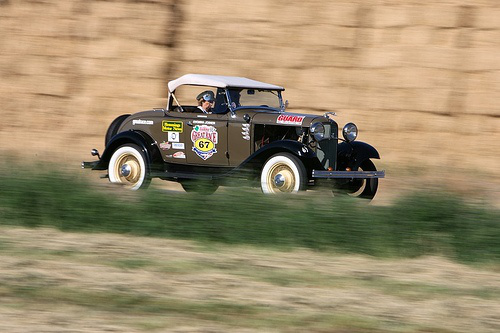

In [12]:
print(dataset.vocab[torch.where(dataset[171][1]==1)[0]])
dataset[171][0]

In [13]:
dls = db.dataloaders(csv, bs=32)

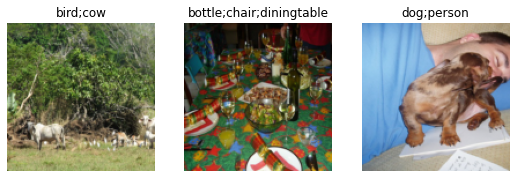

In [14]:
dls.show_batch(nrows=1, ncols=3)

In [ ]:
model = vision.cnn_learner(dls, vision.resnet18)

In [16]:
for data, label in dls.train:
  print(data.shape, label.shape)
  break

torch.Size([32, 3, 128, 128]) torch.Size([32, 20])


In [ ]:
model.model

The architecture of resnet is already changed in the learner to suite our data set

In [20]:
x, y = vision.to_cpu(dls.train.one_batch())

out = model.model(x)
print(out.shape, model.loss_func)

torch.Size([32, 20]) FlattenedLoss of BCEWithLogitsLoss()


In [ ]:
out[0]

In [22]:
def idx2vocab(tens):
  print(dataset.vocab[torch.where(tens.round()==1)[0]])

In [23]:
idx2vocab(out[10])

(#6) ['bottle','diningtable','person','pottedplant','train','tvmonitor']


In [24]:
def binary_cross_entropy(pred, target):
  pred = pred.sigmoid()

  return -torch.where(target==1, pred, 1-pred).log().mean()

Softmax function is used for multi class classification like where there will be only single positive class. Here it is suitable because it boosts a single class by pushing the others down as it divides the exp of every class with that class.


But binary cross entropy is used only when there is a single output like whether the class is present or not, i.e, either 0 or 1.

Therefore, it is very much suitable for multi label classification where the labels are one hot encoded and each label is either a 0 or 1.

There may be multiple ones but each label is either 0 or 1, so binary cross entropy is very much suitable for this.

If softamax is used for multi-label classification, then the sum of whole prediction will be equal to 1 and there will be only single maximum value and others will be very low to increase the confidence of that class, but in binary cross entropy there may be multiple values close to 1, thus we can do multi label classification.

In [25]:
def acc_multi(pred, target, thresh=0.5, sigmoid=True):
  if sigmoid: pred = pred.sigmoid()

  return ((pred>thresh) == target.bool()).float().mean()

In [ ]:
acc_multi(out[0], out[0].sigmoid().round())

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.03981071710586548)

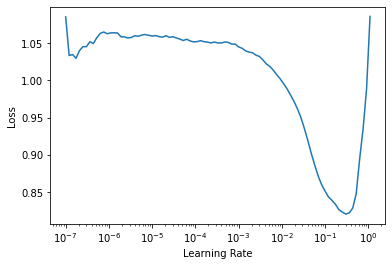

In [63]:
model = vision.cnn_learner(dls, vision.resnet18, metrics=partial(acc_multi, thresh=0.57))
model.lr_find()

In [80]:
model = vision.cnn_learner(dls, vision.resnet18, metrics=partial(acc_multi, thresh=0.57))
model.fine_tune(3, base_lr=0.003, max_lr=slice(0.002, 0.1), freeze_epochs=4)

epoch,train_loss,valid_loss,acc_multi,time
0,0.955748,0.693629,0.696374,00:33
1,0.727833,0.381390,0.907908,00:33
2,0.344301,0.149506,0.948108,00:32
3,0.204533,0.137092,0.951494,00:33


epoch,train_loss,valid_loss,acc_multi,time
0,0.147747,0.129930,0.953327,00:34
1,0.129241,0.120566,0.957231,00:34
2,0.109796,0.118620,0.957689,00:34


In [ ]:
pred, targ = model.get_preds()

In [82]:
pred[0], targ[1]

(tensor([1.6454e-03, 2.4493e-03, 8.3832e-04, 4.6726e-04, 3.9491e-02, 9.8714e-04,
         3.9280e-03, 4.6673e-03, 8.1875e-01, 4.0273e-03, 3.0572e-01, 1.7875e-02,
         2.8572e-03, 9.8405e-04, 1.5684e-01, 1.2275e-01, 8.9384e-04, 2.0871e-01,
         4.9165e-04, 2.9555e-01]),
 tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

In [85]:
model.metrics = partial(acc_multi, thresh=0.5)
loss, acc = model.validate()
print("val_acc: {}\tval_loss: {}".format(loss, acc))

val_acc: 0.11862042546272278	val_loss: 0.9573903679847717


In [86]:
acc_multi(pred, targ, thresh=0.55, sigmoid=False)

tensor(0.9577)

In [87]:
x = torch.linspace(0.05, 0.95)
y = [acc_multi(pred, targ, thresh=i, sigmoid=False) for i in x]

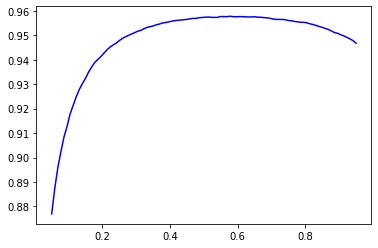

In [89]:
plt.plot(x, y, 'b-')

In [55]:
model.metrics = partial(acc_multi, thresh=0.57)
model.validate()

(#2) [0.11558675020933151,0.9583466649055481]

In [100]:
output = model.model(dls.one_batch()[0])

In [104]:
dls.one_batch()[0][0].shape

torch.Size([3, 128, 128])

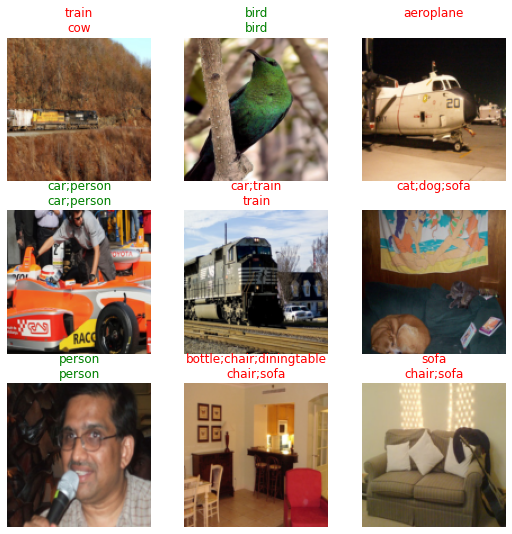

In [112]:
model.metrics = partial(acc_multi, thresh=0.55)
model.show_results()